# 1. 加载数据集

In [1]:
import pandas as pd
from datasets import load_dataset
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt


from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import nltk

# 加载IMDB数据集
dataset = load_dataset("stanfordnlp/imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [2]:
dataset["train"][0], dataset["train"].shape

({'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

In [3]:
type(dataset["train"][0])

dict

In [4]:
# 加载训练和测试数据集
train_data = dataset['train']
test_data = dataset['test']
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_df.head(), test_df.head()

(                                                text  label
 0  I rented I AM CURIOUS-YELLOW from my video sto...      0
 1  "I Am Curious: Yellow" is a risible and preten...      0
 2  If only to avoid making this type of film in t...      0
 3  This film was probably inspired by Godard's Ma...      0
 4  Oh, brother...after hearing about this ridicul...      0,
                                                 text  label
 0  I love sci-fi and am willing to put up with a ...      0
 1  Worth the entertainment value of a rental, esp...      0
 2  its a totally average film with a few semi-alr...      0
 3  STAR RATING: ***** Saturday Night **** Friday ...      0
 4  First off let me say, If you haven't enjoyed a...      0)

In [5]:
from sklearn.utils import shuffle

train_df = shuffle(train_df)

train_df.head()

,text,label
21350,I really enjoyed watching this movie about the...,1
3494,"The film ""52 Pick Up"" simply does not work. Se...",0
17599,"In April of 1965, CBS broadcast the first of B...",1
10759,"Here's an indie film I really wanted to like, ...",0
8916,"If this is someone's ""favorite"" movie, they ne...",0


In [6]:
# train
x_train = train_df['text'].values
y_train = train_df['label'].values
# test
x_test = test_df['text'].values
y_test = test_df['label'].values

x_train[0], y_train[0]

("I really enjoyed watching this movie about the Delany sisters. I knew of them, but that was all. This movie opened my eyes to their bravado and courage. What a pair. What sacrifices they made to live life on their own terms. This is not only a movie for African Americans, but for all Americans. It is sort of a history lesson and a documentary rolled into one and combined with an entertaining movie biography. The acting was superior by all included and we really do get a glimpse of the hardships these two sisters went through for many years. Both sisters are quite different from each other. They came from a very loving and very strict family with high, maybe even impossible standards of perfection. It is sad to see how Sadie's father refused to allow his daughter to continue to see her boyfriend due to a possible misunderstanding. I thoroughly recommend this movie and I am glad I caught it on television the other day.",
 1)

In [7]:
len(y_train), len(y_test)

(25000, 25000)

In [8]:
import os

if not os.path.exists('label'):
    os.makedirs('label')

# 持久化 y_train, t_test, 他们是标签数组，不需要再次处理,保存为csv格式
pd.DataFrame(y_train).to_csv("label/y_train.csv", index=False, header=False)
pd.DataFrame(y_test).to_csv("label/y_test.csv", index=False, header=False)


# 2. 数据预处理

## 2.1 文本预处理：去除html标签,标点符号和停用词

* 下载英文的停用词表
* 将文本库转为小写
* 在英文中 `-` 常作为连接次，替换成 空格
* 使用正则删除html标记和标点 

    正则表达式 r'[^\w\s]' 的含义如下：
    * \w：匹配任何字母数字字符，等同于字符集 [a-zA-Z0-9_]。
    * \s：匹配任何空白字符，包括空格、制表符、换页符等。
    * [^...]：匹配不在方括号内的任何字符。所以，[^\w\s] 匹配任何非字母数字和非空白字符的字符，即所有的标点符号。

* 使用`tokenizer`分词
* 去除停用词

In [9]:
nltk.download('stopwords')  # 下载停用词
nltk.download('punkt')  # 下载分词需要的数据

stop_words = set(stopwords.words('english'))  # 停用词

stop_words

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shuyuanzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [10]:
def preprocess_text(text):
    # 去除html标签
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()  # 转小写
    word_tokens = word_tokenize(text)  # 分词
    filtered_text = [word for word in word_tokens if word not in stop_words]  # 去除停用词
    text = ' '.join(filtered_text)
    text = text.replace("-", " ")  # 英文中 `-` 通常表示连接词，将其替换为空格
    text = re.sub(r'[^\w\s]', '', text)  # 去除标点符号
    text = re.sub(r'\d+', '', text)   # 去除数字
    text = re.sub(r'\s+', ' ', text)   # 将多个空格合并为一个空格
    return text

In [11]:
print(x_train[0])
print(preprocess_text(x_train[0]))

I really enjoyed watching this movie about the Delany sisters. I knew of them, but that was all. This movie opened my eyes to their bravado and courage. What a pair. What sacrifices they made to live life on their own terms. This is not only a movie for African Americans, but for all Americans. It is sort of a history lesson and a documentary rolled into one and combined with an entertaining movie biography. The acting was superior by all included and we really do get a glimpse of the hardships these two sisters went through for many years. Both sisters are quite different from each other. They came from a very loving and very strict family with high, maybe even impossible standards of perfection. It is sad to see how Sadie's father refused to allow his daughter to continue to see her boyfriend due to a possible misunderstanding. I thoroughly recommend this movie and I am glad I caught it on television the other day.
really enjoyed watching movie delany sisters knew movie opened eyes b

In [12]:
# 对训练集和测试集进行预处理
x_train = [preprocess_text(text) for text in x_train]
x_test = [preprocess_text(text) for text in x_test]

In [13]:
# 持久化处理后的数据
if not os.path.exists('processed'):
    os.makedirs('processed')
pd.DataFrame(x_train).to_csv("processed/x_train.csv", index=False, header=False)
pd.DataFrame(x_test).to_csv("processed/x_test.csv", index=False, header=False)

In [14]:
x_train[0], x_test[0]

('really enjoyed watching movie delany sisters knew movie opened eyes bravado courage pair sacrifices made live life terms movie african americans americans sort history lesson documentary rolled one combined entertaining movie biography acting superior included really get glimpse hardships two sisters went many years sisters quite different came loving strict family high maybe even impossible standards perfection sad see sadie s father refused allow daughter continue see boyfriend due possible misunderstanding thoroughly recommend movie glad caught television day ',
 'love sci fi willing put lot sci fi moviestv usually underfunded under appreciated misunderstood tried like really good tv sci fi babylon star trek original silly prosthetics cheap cardboard sets stilted dialogues cg nt match background painfully one dimensional characters overcome sci fi setting m sure think babylon good sci fi tv s s clichéd uninspiring us viewers might like emotion character development sci fi genre ta

## 2.2 文本向量化

### 2.2.1 BOW 和 TF-IDF向量化

In [15]:
max_features = 5000

In [16]:
# BOW 特征提取
bow_vectorizer = CountVectorizer(max_features=max_features)
bow_train_vector = bow_vectorizer.fit_transform(x_train)
bow_test_vector = bow_vectorizer.transform(x_test)

In [17]:
# TF-IDF 特征提取
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_train_vector = tfidf_vectorizer.fit_transform(x_train)
tfidf_test_vector = tfidf_vectorizer.transform(x_test)

将 `BOW` 向量和 `tf-idf` 向量持久化到磁盘

In [18]:
import os
import pickle

path = 'features/max_features_{}'.format(max_features)

if not os.path.exists(path):
    os.makedirs(path)
with open(path + '/bow_train_vector.pkl', 'wb') as f:
    pickle.dump(bow_train_vector, f)
with open(path + '/bow_test_vector.pkl', 'wb') as f:
    pickle.dump(bow_test_vector, f)
with open(path + '/tfidf_train_vector.pkl', 'wb') as f:
    pickle.dump(tfidf_train_vector, f)
with open(path + '/tfidf_test_vector.pkl', 'wb') as f:
    pickle.dump(tfidf_test_vector, f)

print("BOW和TF-IDF特征已持久化到磁盘。")

BOW和TF-IDF特征已持久化到磁盘。


### 2.2.2 Word2Vec 向量化
在这里，我想直接使用在 `Google-news` 上预训练的 `Word2Vec` 模型

使用预训练的 Word2Vec 模型可以显著提高文本向量化的质量，由于在大规模的文本库上进行了预训练，因此能够捕捉到更广泛的语义信息。

同时得益于他人预训练的工作，我们可以节省训练一个语言模型的算力和时间

使用预训练模型，这也是当今自然语言处理中的主流做法

In [19]:
def load_w2v_model():
    from gensim.models import KeyedVectors
    # 使用 gensim 加载预训练的 Google News Word2Vec 模型
    word2vec_path = 'GoogleNews-vectors-negative300.bin'
    if not os.path.exists(word2vec_path):
        print("Downloading pre-trained Word2Vec model...")
        import gensim.downloader as api
        model = api.load("word2vec-google-news-300")
        model.save_word2vec_format(word2vec_path, binary=True)
    else:
        model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    # 加载预训练的 Google News Word2Vec 模型
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    return w2v_model

# 加载预训练的 Google News Word2Vec 模型
w2v_model = load_w2v_model()

In [20]:
# 查看词向量的维度和前5个值
w2v_model['hello'].shape, w2v_model['hello'][:5]

((300,),
 array([-0.05419922,  0.01708984, -0.00527954,  0.33203125, -0.25      ],
       dtype=float32))

#### 2.2.2.1 获取文档的平均词向量表示
Word2Vec 获得的是单个词语的项链表示，将单个词语映射到一个 300 维的向量表示

为了获得文档的向量表示，一个简单直接而有效的做法是，计算文档中所有词向量的平均值。

我们通过这种方式获得文档的嵌入向量表示

In [21]:
# 获取每个文档的平均词向量
def get_avg_word2vec(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token in w2v_model]
    if len(tokens) == 0:
        return np.zeros(300)
    vectors = [w2v_model[token] for token in tokens]
    vectors = np.array(vectors)
    avg_vector = np.mean(vectors, axis=0)
    return avg_vector

# 计算训练集和测试集的平均词向量
avg_w2v_train = np.array([get_avg_word2vec(text) for text in x_train])
avg_w2v_test = np.array([get_avg_word2vec(text) for text in x_test])

In [22]:
path = 'features/word2vec_avg'
if not os.path.exists(path):
    os.makedirs(path)
# 持久化平均词向量
with open(path + '/avg_w2v_train.pkl', 'wb') as f:
    pickle.dump(avg_w2v_train, f)
with open(path + '/avg_w2v_test.pkl', 'wb') as f:
    pickle.dump(avg_w2v_test, f)

给出一个从磁盘中读取 bow, tf-idf, word2vec向量的方法，使得预处理的数据可以在后面直接加载，使得 jupyter 笔记本的代码不用严格的顺序执行，防止内存爆炸

In [23]:
def load_features():
    with open('features/max_features_5000/bow_train_vector.pkl', 'rb') as f:
        bow_train_vector = pickle.load(f)
    with open('features/max_features_5000/bow_test_vector.pkl', 'rb') as f:
        bow_test_vector = pickle.load(f)
    with open('features/max_features_5000/tfidf_train_vector.pkl', 'rb') as f:
        tfidf_train_vector = pickle.load(f)
    with open('features/max_features_5000/tfidf_test_vector.pkl', 'rb') as f:
        tfidf_test_vector = pickle.load(f)
    with open('features/max_features_5000/avg_w2v_train.pkl', 'rb') as f:
        avg_w2v_train = pickle.load(f)
    with open('features/max_features_5000/avg_w2v_test.pkl', 'rb') as f:
        avg_w2v_test = pickle.load(f)
    return bow_train_vector, bow_test_vector, tfidf_train_vector, tfidf_test_vector, avg_w2v_train, avg_w2v_test

#### 2.2.2.2 获取文档的序列词向量表示

在序列模型中，我们把文档看成若干个词的有序排列，这种序列特征包含了复杂的语意特征

将一个文档的所有词向量求平均得到的词向量表示默认是认为词语之间的排列是无序的

但是很明显，词语的顺序构成了复杂的语意

所以我们这里还需要制作一个序列词向量的表示

max: 1452, mean: 124.53356
std: 94.28825925705914
mean + 3*std = 407.39833777117735


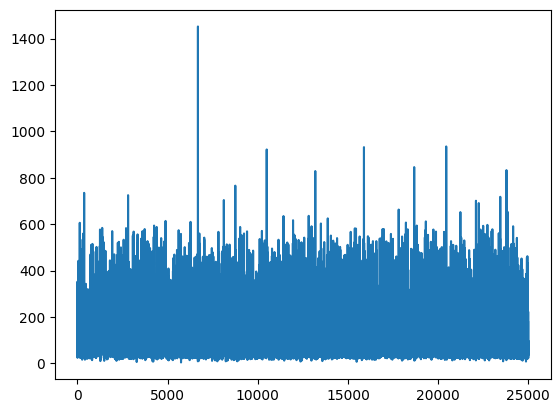

In [24]:
# 查看一下序列的最大长度
def get_length(text):
    return len(text.split())

lengths = [get_length(text) for text in x_train]
max_length = max(lengths)
mean_length = np.mean(lengths)
print("max: {}, mean: {}".format(max_length, mean_length))
# 标准差
std = np.std(lengths)
print("std: {}".format(std))
print('mean + 3*std = {}'.format(mean_length + 3 * std))
plt.plot(lengths)

In [25]:
# 计算能够涵盖 99% 训练集文本的序列长度
lengths = np.array(lengths)
lengths = np.sort(lengths)
n = len(lengths)
p = 0.99
index = int(n * p)
max_length = lengths[index]
max_length

485

In [26]:
x_train[0]

'really enjoyed watching movie delany sisters knew movie opened eyes bravado courage pair sacrifices made live life terms movie african americans americans sort history lesson documentary rolled one combined entertaining movie biography acting superior included really get glimpse hardships two sisters went many years sisters quite different came loving strict family high maybe even impossible standards perfection sad see sadie s father refused allow daughter continue see boyfriend due possible misunderstanding thoroughly recommend movie glad caught television day '

In [27]:
# 获取每个文档的词向量
# 我们规定一个序列的最大长度为485，不足485的用0填充
def get_word2vec(text, max_len=485):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token in w2v_model]
    vectors = [w2v_model[token] for token in tokens]
    if len(vectors) > max_len:
        vectors = vectors[:max_len]
    else:
        padding = [np.zeros(300)] * (max_len - len(vectors))
        vectors.extend(padding)
    return np.array(vectors)

# 获得词向量数据集
x_train_w2v = np.array([get_word2vec(text) for text in x_train])
x_test_w2v = np.array([get_word2vec(text) for text in x_test])

In [29]:
x_train_w2v.shape

(25000, 485, 300)

In [31]:
# 持久化词向量数据集
path = 'features/word2vec'
if not os.path.exists(path):
    os.makedirs(path)
with open(path + '/x_train_w2v.pkl', 'wb') as f:
    pickle.dump(x_train_w2v, f)
with open(path + '/x_test_w2v.pkl', 'wb') as f:
    pickle.dump(x_test_w2v, f)

In [1]:
def get_word2vec_features():
    with open('features/word2vec/x_train_w2v.pkl', 'rb') as f:
        x_train_w2v = pickle.load(f)
    with open('features/word2vec/x_test_w2v.pkl', 'rb') as f:
        x_test_w2v = pickle.load(f)
    return x_train_w2v, x_test_w2v

# 3. 使用机器学习模型训练并预测

## 3.1 评估指标
这是一个分类任务，我们采用一些常见指标进行模型评估

1. Accuracy（准确率）：


* 定义：模型预测正确的样本数占总样本数的比例。
* 计算公式： $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
	* 其中，TP（True Positive）是真正类正例数，TN（True Negative）是真正类反例数，FP（False Positive）是误判为正例的反例数，FN（False Negative）是误判为反例的正例数。


2.	Precision（精确率）：


* 定义：模型预测为正例的样本中真正类正例的比例。
* 计算公式： $\text{Precision} = \frac{TP}{TP + FP} $


3.	Recall（召回率）：


* 定义：真正类正例中被模型正确预测为正例的比例。
* 计算公式： $\text{Recall} = \frac{TP}{TP + FN} $

	
4.	F1-score：


* 定义：精确率和召回率的调和平均数，综合考虑了精确率和召回率。
* 计算公式：$ \text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $

5. ROC 曲线


* 定义：ROC 曲线是通过不同阈值下计算的 TPR（True Positive Rate，真正率）和 FPR（False Positive Rate，假正率）来绘制的。它的横轴是 FPR，纵轴是 TPR。
* TPR（真正率）或 Recall： ¥\text{TPR} = \frac{TP}{TP + FN} ¥
* FPR（假正率）： $\text{FPR} = \frac{FP}{FP + TN} $

6. AUC


* 定义：AUC 是 ROC 曲线下面积。它的值介于 0.5 到 1 之间，越接近 1，模型的性能越好。

* AUC 的值解释：
* 0.5：模型没有分类能力（与随机猜测一样）
* 0.5 到 0.7：模型有一定的分类能力
* 0.7 到 0.9：模型有较好的分类能力
* 0.9 到 1：模型有很好的分类能力


**在 `utils.py` 中实现了对模型的评估方法**


## 3.2 朴素贝叶斯


In [16]:
# 朴素贝叶斯
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

def train_and_evaluate(features_class):
    use_gaussian = False
    match features_class:
        case "bow":
            train = bow_train_vector
            test = bow_test_vector
        case "tfidf":
            train = tfidf_train_vector
            test = tfidf_test_vector
        case "word2vec":
            train = avg_w2v_train
            test = avg_w2v_test
            use_gaussian = True
        case _:
            print("Invalid features class")
            return
        
    classifier = GaussianNB() if use_gaussian else MultinomialNB()
    classifier.fit(train, y_train)
    predict_result = classifier.predict(test)
    predict_prob = classifier.predict_proba(test)[:, 1]
    model_name = "naive_bayes " + features_class
    print_evaluation_scores(model_name, y_test, predict_result)
    plot_roc_curve(model_name, y_test, predict_prob)

#### 3.2.1.1 使用BOW特征

naive_bayes bow Model Evaluation
Accuracy: 0.8349
Precision: 0.8553
Recall: 0.8062
F1 Score: 0.8300


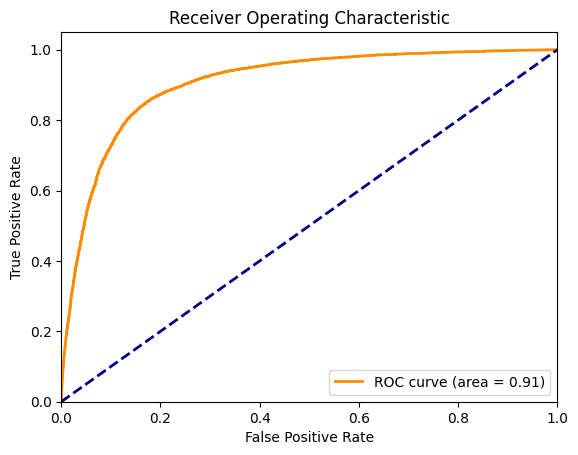

<Figure size 640x480 with 0 Axes>

In [17]:
train_and_evaluate("bow")

#### 3.2.1.2 使用TF-IDF特征

naive_bayes tfidf Model Evaluation
Accuracy: 0.8390
Precision: 0.8517
Recall: 0.8210
F1 Score: 0.8360


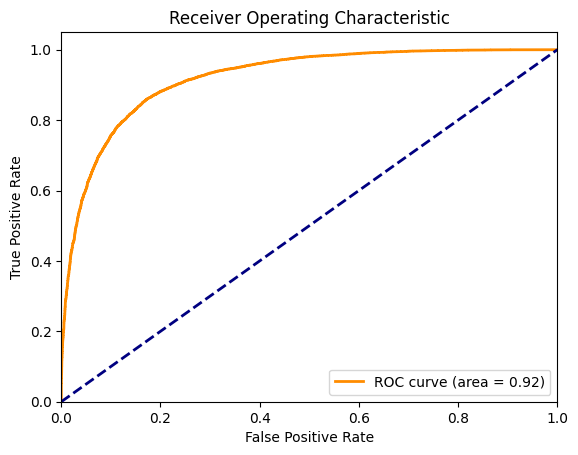

<Figure size 640x480 with 0 Axes>

In [18]:
train_and_evaluate("tfidf")

#### 3.2.1.3 使用 Word2Vec 向量

naive_bayes word2vec Model Evaluation
Accuracy: 0.7687
Precision: 0.7887
Recall: 0.7341
F1 Score: 0.7604


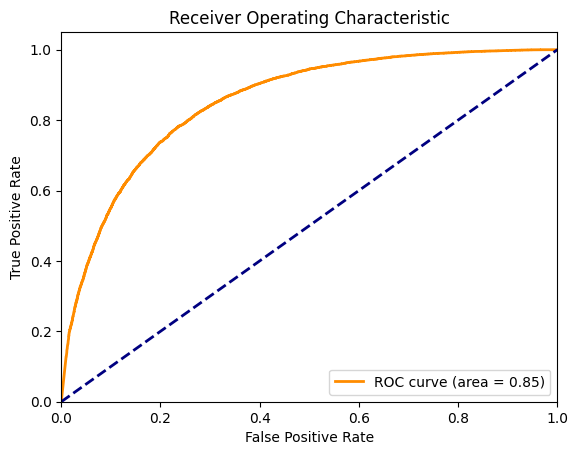

<Figure size 640x480 with 0 Axes>

In [20]:
train_and_evaluate("word2vec")

#### 3.3 XGBoost


##### 可调参数
分为三类：**通用参数、Booster 参数和学习任务参数。**

通用参数 (General Parameters)

这些参数控制整体的 XGBoost 运行配置。

1.	booster：选择模型类型。
	* gbtree：基于树的模型（默认）。
	* gblinear：线性模型。
	* dart：基于树的模型，带 Dropout。
2.	nthread：线程数。默认是最大可用线程数。
3.	verbosity：控制输出信息。
	* 0 (silent)：不输出。
	* 1 (warning)：只输出警告信息。
	* 2 (info)：输出信息（默认）。
	* 3 (debug)：输出调试信息。

Booster 参数

这些参数控制具体的 Booster（提升器）的训练细节。

树 Booster 参数 (Tree Booster Parameters)

适用于 gbtree 和 dart。

1. eta (learning_rate)：学习率，降低每一步的权重（通常设置为 0.01-0.3）。
2. max_depth：树的最大深度（默认 6）。
3. min_child_weight：子节点中最小的样本权重和，防止过拟合（默认 1）。
4. gamma：节点分裂所需的最小损失减少量，防止过拟合（默认 0）。
5. subsample：每棵树训练时使用的数据占整个数据的比例，防止过拟合（通常设置为 0.5-1）。
6. colsample_bytree：每棵树训练时使用的特征比例（通常设置为 0.5-1）。
7. colsample_bylevel：树的每一级训练时使用的特征比例（默认 1）。
8. colsample_bynode：树的每个节点训练时使用的特征比例（默认 1）。
9. lambda (reg_lambda)：L2 正则化项权重，防止过拟合（默认 1）。
10. alpha (reg_alpha)：L1 正则化项权重，防止过拟合（默认 0）。
11. scale_pos_weight：控制正负样本不平衡时的平衡（默认为 1）。

线性 Booster 参数 (Linear Booster Parameters)

适用于 gblinear。

1. lambda (reg_lambda)：L2 正则化项权重。
2. alpha (reg_alpha)：L1 正则化项权重。
3. updater：更新方式，可选择 shotgun 和 coord_descent。
4. feature_selector：特征选择方式，可选择 cyclic, shuffle, random, greedy, thrifty。

DART Booster 参数 (DART Booster Parameters)

适用于 dart。

1. sample_type：选择 Dropout 类型，可选择 uniform 或 weighted。
2. normalize_type：Dropout 后的标准化类型，可选择 tree 或 forest。
3. rate_drop：每次 Dropout 的比例（默认 0.0）。
4. skip_drop：不进行 Dropout 的概率（默认 0.0）。

学习任务参数 (Learning Task Parameters)

这些参数控制模型的学习任务及目标。

1. objective：定义需要优化的损失函数。
	* reg:squarederror：回归平方损失。
	* reg:logistic：逻辑回归。
	* binary:logistic：二分类的逻辑回归。
	* binary:logitraw：输出未经变换的逻辑回归值。
	* multi:softmax：多分类的 softmax 目标函数，返回分类编号。
	* multi:softprob：多分类的 softmax 目标函数，返回每类的概率。
	* rank:pairwise：排序任务。
	* 其他自定义目标函数。
2. eval_metric：用于验证数据的评估指标。
	* rmse：均方根误差。
	* mae：平均绝对误差。
	* logloss：对数损失。
	* error：二分类错误率。
	* merror：多分类错误率。
	* mlogloss：多分类对数损失。
	* 其他自定义评估指标。
3. seed：随机数种子，保证结果的可重复性。

In [10]:
def get_train_test_data(features_class):
    match features_class:
        case "bow":
            train = bow_train
            test = bow_test
            print("BOW 特征")
        case "tfidf":
            train = tfidf_train
            test = tfidf_test
            print("TF-IDF 特征")
        case "word2vec":
            train = avg_w2v_train
            test = avg_w2v_test
            print("Word2Vec 特征")
        case _:
            print("Invalid features class")
            return None, None
    return train, test

In [30]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

def train_and_evaluate_with_cv(features_class):
    train, _ = get_train_test_data(features_class)
    if train is None:
        return
    classifier = XGBClassifier(objective='binary:logistic')
    param_grid = {
        'n_estimators': [200, 300],
        'max_depth': [7, 8],
        'learning_rate': [0.1, 0.2],
        'subsample': [0.6, 0.8]
    }
    grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    grid_search.fit(train, y_train)
    best_params = grid_search.best_params_
    print("Best parameters for {}:".format(features_class), best_params)
    return best_params

In [22]:
def train_and_test(features_class):
    train, test = get_train_test_data(features_class)
    if train is None or test is None:
        return
    best_params = train_and_evaluate_with_cv(features_class)
    print("Best params for {}: {}".format(features_class, best_params))
    if train is None or test is None:
        return
    classifier = XGBClassifier(objective='binary:logistic', **best_params)
    classifier.fit(train, y_train)
    predict_result = classifier.predict(test)
    predict_prob = classifier.predict_proba(test)[:, 1]
    model_name = "XGBoost" + features_class
    print_evaluation_scores(model_name, y_test, predict_result)
    plot_roc_curve(model_name, y_test, predict_prob)

In [23]:
def simple_train_test(features_class):
    train, test = get_train_test_data(features_class)
    if train is None or test is None:
        return
    classifier = XGBClassifier(objective='binary:logistic')
    classifier.fit(train, y_train)
    predict_result = classifier.predict(test)
    predict_prob = classifier.predict_proba(test)[:, 1]
    model_name = "XGBoost" + features_class
    print_evaluation_scores(model_name, y_test, predict_result)
    plot_roc_curve(model_name, y_test, predict_prob)

##### 3.2.2.3.1 BOW

BOW 特征
XGBoostbow Model Evaluation
Accuracy: 0.8543
Precision: 0.8444
Recall: 0.8686
F1 Score: 0.8563


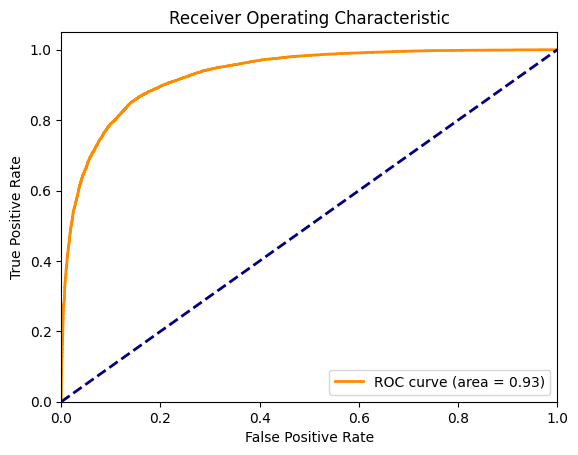

<Figure size 640x480 with 0 Axes>

In [24]:
simple_train_test("bow")

BOW 特征
BOW 特征
Best parameters for bow: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}
Best params for bow: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}
XGBoostbow Model Evaluation
Accuracy: 0.8664
Precision: 0.8606
Recall: 0.8744
F1 Score: 0.8674


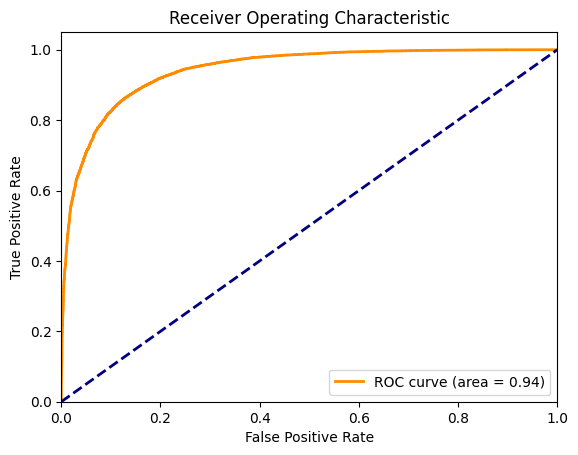

<Figure size 640x480 with 0 Axes>

In [25]:
train_and_test("bow")


Best parameters for bow: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}

##### 3.2.2.3.2 tf-idf

TF-IDF 特征
XGBoosttfidf Model Evaluation
Accuracy: 0.8493
Precision: 0.8373
Recall: 0.8670
F1 Score: 0.8519


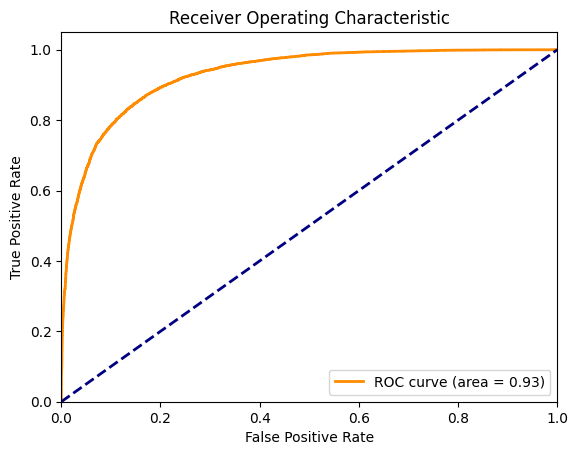

<Figure size 640x480 with 0 Axes>

In [26]:
simple_train_test("tfidf")

TF-IDF 特征
TF-IDF 特征
Best parameters for tfidf: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Best params for tfidf: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
XGBoosttfidf Model Evaluation
Accuracy: 0.8660
Precision: 0.8595
Recall: 0.8749
F1 Score: 0.8671


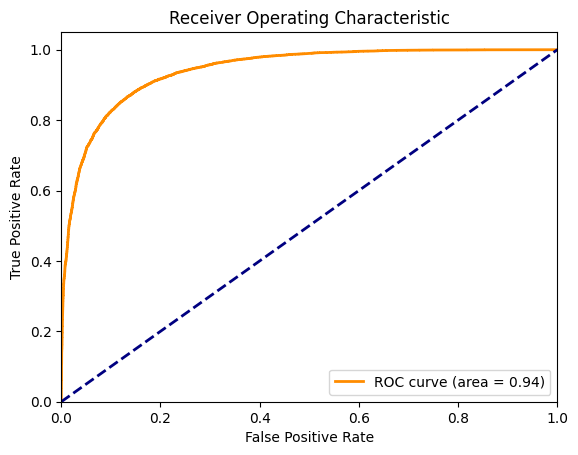

<Figure size 640x480 with 0 Axes>

In [27]:
train_and_test("tfidf")

Best parameters for tfidf: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}

##### 3.2.2.3.1 word2vec

TF-IDF 特征
XGBoosttfidf Model Evaluation
Accuracy: 0.8493
Precision: 0.8373
Recall: 0.8670
F1 Score: 0.8519


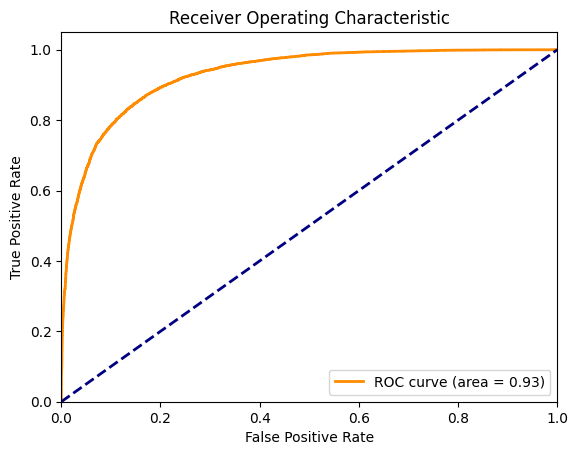

<Figure size 640x480 with 0 Axes>

In [28]:
simple_train_test("tfidf")

Word2Vec 特征
Word2Vec 特征


/opt/miniconda3/envs/dm_2024_fall/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for word2vec: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Best params for word2vec: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
XGBoostword2vec Model Evaluation
Accuracy: 0.8458
Precision: 0.8450
Recall: 0.8470
F1 Score: 0.8460


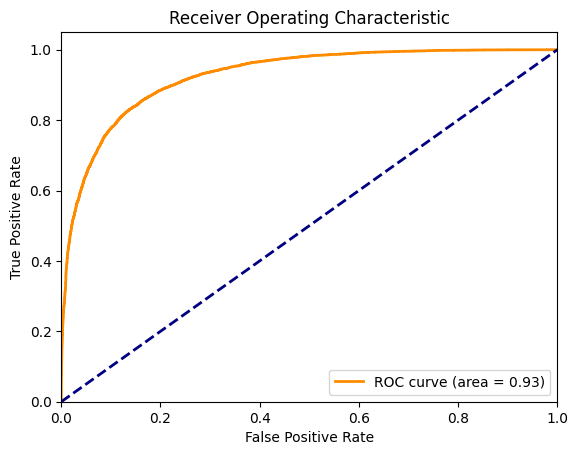

<Figure size 640x480 with 0 Axes>

In [29]:
train_and_test("word2vec")

Best parameters for word2vec: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}

## 3.3 深度学习算法训练和评测

### 3.3.1 多层感知机

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

In [12]:
# 获取 bow tf-idf word2vec 处理后的特征
bow_train_vector, bow_test_vector, tfidf_train_vector, tfidf_test_vector, avg_w2v_train, avg_w2v_test = load_features()
# 获取标签
y_train = pd.read_csv('label/y_train.csv', header=None).values.ravel()
y_test = pd.read_csv('label/y_test.csv', header=None).values.ravel()

In [13]:
# 超参数
bz = 64
num_epochs = 100
lr = 0.01
hidden_dim = 100
output_dim = 1

In [37]:
# 定义loss
loss = nn.BCEWithLogitsLoss()

Epoch: 10, Loss: 0.0002999239950440824
Epoch: 20, Loss: 0.000947503955103457
Epoch: 30, Loss: 1.5768184312037192e-05
Epoch: 40, Loss: 3.2983668916131137e-06
Epoch: 50, Loss: 3.112516537839838e-07
Epoch: 60, Loss: 1.5768864614074118e-06
Epoch: 70, Loss: 1.4983939422563708e-07
Epoch: 80, Loss: 4.161505273714283e-07
Epoch: 90, Loss: 2.400893173160057e-08
Epoch: 100, Loss: 7.915339494957152e-09
MLP BoW Model Evaluation
Accuracy: 0.8510
Precision: 0.8593
Recall: 0.8395
F1 Score: 0.8493


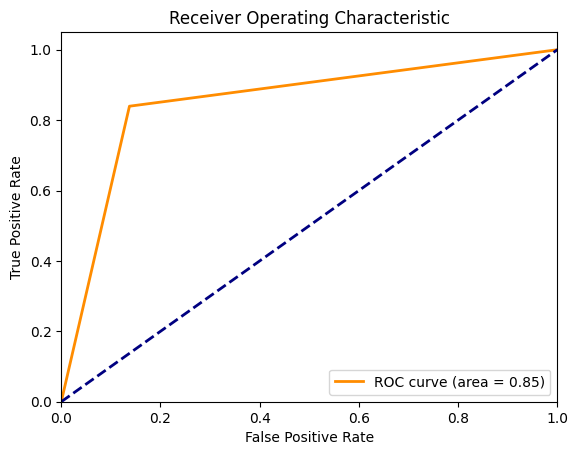

In [40]:
# BOW
input_dim = bow_train_vector.shape[1]
model = MLP(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

# 准备 Bow 数据
train_dataset = TensorDataset(torch.from_numpy(bow_train_vector.toarray()).float(), torch.from_numpy(y_train).reshape((-1, 1)).float())
train_dataloader= DataLoader(train_dataset, batch_size=bz, shuffle=True)
# 训练模型
train_model(model, train_dataloader, optimizer, loss, num_epochs)

# 预测
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(bow_test_vector.toarray()).float()).numpy().ravel()
y_pred = (y_pred > 0).astype(int)
y_pred_proba_MLP_bow = torch.sigmoid(torch.from_numpy(y_pred)).numpy().ravel()
print_evaluation_scores("MLP BoW", y_test, y_pred)
plot_roc_curve(y_test, y_pred_proba_MLP_bow)

Epoch: 10, Loss: 0.0007214356446638703
Epoch: 20, Loss: 4.4250075006857514e-05
Epoch: 30, Loss: 9.065077756531537e-05
Epoch: 40, Loss: 1.9753804735955782e-05
Epoch: 50, Loss: 8.277986012217298e-07
Epoch: 60, Loss: 3.4352515854152443e-07
Epoch: 70, Loss: 2.4523790997932338e-08
Epoch: 80, Loss: 4.065891623383777e-09
Epoch: 90, Loss: 1.7209421665498326e-09
Epoch: 100, Loss: 2.4165589529445697e-09
MLP TF-IDF Model Evaluation
Accuracy: 0.8452
Precision: 0.8656
Recall: 0.8173
F1 Score: 0.8408


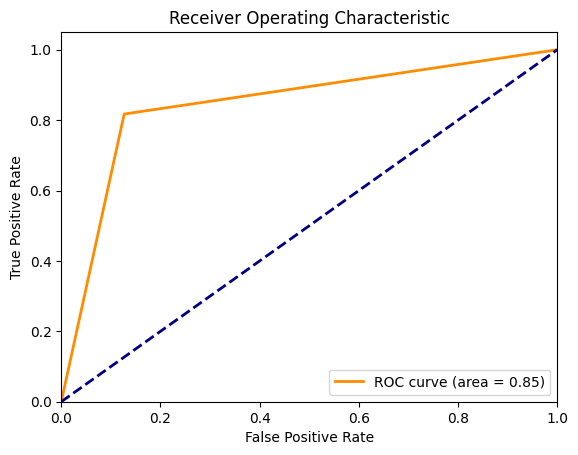

In [41]:
# TF-IDF
input_dim = tfidf_train_vector.shape[1]
model = MLP(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

## 准备 TF-IDF 数据
train_dataset = TensorDataset(torch.from_numpy(tfidf_train_vector.toarray()).float(), torch.from_numpy(y_train).reshape((-1, 1)).float())
train_dataloader= DataLoader(train_dataset, batch_size=bz, shuffle=True)
# 训练模型
train_model(model, train_dataloader, optimizer, loss, num_epochs)
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(tfidf_test_vector.toarray()).float()).numpy().ravel()
y_pred = (y_pred > 0).astype(int)
y_pred_proba_MLP_tfidf = torch.sigmoid(torch.from_numpy(y_pred)).numpy().ravel()
print_evaluation_scores("MLP TF-IDF", y_test, y_pred)
plot_roc_curve(y_test, y_pred_proba_MLP_tfidf)

Epoch: 10, Loss: 0.3538975119590759
Epoch: 20, Loss: 0.224770188331604
Epoch: 30, Loss: 0.41226139664649963
Epoch: 40, Loss: 0.30746546387672424
Epoch: 50, Loss: 0.27053359150886536
Epoch: 60, Loss: 0.3417244255542755
Epoch: 70, Loss: 0.34842056035995483
Epoch: 80, Loss: 0.3489134907722473
Epoch: 90, Loss: 0.4429852366447449
Epoch: 100, Loss: 0.25704196095466614
Epoch: 110, Loss: 0.16655318439006805
Epoch: 120, Loss: 0.3118409812450409
Epoch: 130, Loss: 0.41730156540870667
Epoch: 140, Loss: 0.28274044394493103
Epoch: 150, Loss: 0.2672824263572693
Epoch: 160, Loss: 0.23064012825489044
Epoch: 170, Loss: 0.2079649269580841
Epoch: 180, Loss: 0.4491366446018219
Epoch: 190, Loss: 0.27981632947921753
Epoch: 200, Loss: 0.2338114082813263
Epoch: 210, Loss: 0.13261650502681732
Epoch: 220, Loss: 0.2692161202430725
Epoch: 230, Loss: 0.3811137080192566
Epoch: 240, Loss: 0.20026178658008575
Epoch: 250, Loss: 0.16202664375305176
Epoch: 260, Loss: 0.2585476338863373
Epoch: 270, Loss: 0.149580806493759

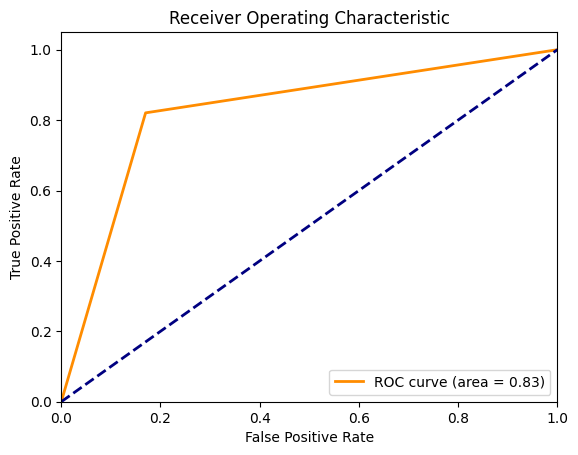

In [44]:
num_epochs = 500

# Word2Vec
input_dim = avg_w2v_train.shape[1]
model = MLP(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

## 准备 Word2Vec 数据
train_dataset = TensorDataset(torch.from_numpy(avg_w2v_train).float(), torch.from_numpy(y_train).reshape((-1, 1)).float())
train_dataloader= DataLoader(train_dataset, batch_size=bz, shuffle=True)
# 训练模型
train_model(model, train_dataloader, optimizer, loss, num_epochs)
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(avg_w2v_test).float()).numpy().ravel()
y_pred = (y_pred > 0).astype(int)
y_pred_proba_MLP_w2v = torch.sigmoid(torch.from_numpy(y_pred)).numpy().ravel()
print_evaluation_scores("MLP Word2Vec", y_test, y_pred)
plot_roc_curve(y_test, y_pred_proba_MLP_w2v)